In [141]:
import pandas as pd
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
folder_path = 'mouseDataExpBCompl'


exclude_ids = ['9468', '9902',  # Error Outlier
               '2786', '6382', '6892',  # Bugs
               '5883',  # Incomplete Data
               '2878', '4420', '2523', '9025']  # Touchpad User

csv_files = glob.glob(os.path.join(folder_path, '*.csv'))
filtered_files = [
    file for file in csv_files
    if not any(ex_id in os.path.basename(file) for ex_id in exclude_ids)
]

# Einlesen
dataframes = [pd.read_csv(file) for file in filtered_files]
# filenames = [os.path.basename(file) for file in csv_files]


In [142]:
exclusion_df = pd.read_csv('df_for_trialexclusion.csv') 
# habe in trialexecution block zu round umbenannt
excluded = exclusion_df[exclusion_df['trial_excl'] == 1][['id', 'round', 'trial']]
dataframes_without_excluded = []

for df in dataframes:
    if all(col in df.columns for col in ['id', 'round', 'trial']):
        merged = df.merge(excluded, on=['id', 'round', 'trial'], how='left', indicator=True)
        df_cleaned = merged[merged['_merge'] == 'left_only'].drop(columns=['_merge'])
        dataframes_without_excluded.append(df_cleaned)
    else:
        dataframes_without_excluded.append(df) 

In [143]:
print(len(dataframes_without_excluded[0]))
print(len(dataframes[0]))

88112
96422


In [144]:
dataframes_without_excluded = [
    df for df in dataframes_without_excluded
    if isinstance(df, pd.DataFrame) and not df.empty
]

In [145]:
len(dataframes_without_excluded)

50

In [146]:
block_pairs = [(1, 2), (3, 4), (5, 6), (7, 8)]
all_blocks = {f"{a}_{b}": [] for a, b in block_pairs}

for df in dataframes:
    df = df[df['phase'] != 'waitingForTarget']  # Phase-Filter
    for a, b in block_pairs:
        df_block = df[df['round'].isin([a, b])].reset_index(drop=True)
        all_blocks[f"{a}_{b}"].append(df_block)

In [147]:
grouped_blocks = {
    '1_2': [],
    '3_4': [],
    '5_6': [],
    '7_8': []
}

for key in grouped_blocks.keys():
    for df in all_blocks[key]:
        df_grouped = df.groupby(['round', 'trial']).agg({
            'timestamp': list,
            'mouse_x': list,
            'mouse_y': list,
            'version': 'first',
            'id': 'first'
        }).reset_index()
        grouped_blocks[key].append(df_grouped)


In [148]:
grouped_df_1_2 = grouped_blocks["1_2"]
grouped_df_3_4 = grouped_blocks["3_4"]
grouped_df_5_6 = grouped_blocks["5_6"]
grouped_df_7_8 = grouped_blocks["7_8"]

In [149]:
len(grouped_df_1_2)

52

In [150]:
def normalize_positions(row):
    # Normalisieren (Startpunkt auf 0,0 setzen)
    x_positions = np.array(row["mouse_x"])
    y_positions = np.array(row["mouse_y"])
    
    x_start, y_start = x_positions[0], y_positions[0]
    x_norm = x_positions - x_start
    y_norm = y_positions - y_start

    row["mouse_x"] = x_norm
    row["mouse_y"] = y_norm

    return row


In [151]:
grouped_dfs = {
    '1_2': grouped_df_1_2,
    '3_4': grouped_df_3_4,
    '5_6': grouped_df_5_6,
    '7_8': grouped_df_7_8
}

processed_dfs = {}

for key, df_list in grouped_dfs.items():
    processed_dfs[key] = [df.apply(normalize_positions, axis=1) for df in df_list]


In [152]:
processed_dfs

{'1_2': [     round  trial                                          timestamp  \
  0        1      1  [14:14:14.373, 14:14:14.390, 14:14:14.409, 14:...   
  1        1      2  [14:14:18.273, 14:14:18.289, 14:14:18.307, 14:...   
  2        1      3  [14:14:21.623, 14:14:21.639, 14:14:21.657, 14:...   
  3        1      4  [14:14:25.489, 14:14:25.507, 14:14:25.523, 14:...   
  4        1      5  [14:14:30.040, 14:14:30.056, 14:14:30.073, 14:...   
  ..     ...    ...                                                ...   
  115      2     56  [14:21:05.375, 14:21:05.389, 14:21:05.410, 14:...   
  116      2     57  [14:21:08.561, 14:21:08.573, 14:21:08.590, 14:...   
  117      2     58  [14:21:11.806, 14:21:11.823, 14:21:11.841, 14:...   
  118      2     59  [14:21:14.840, 14:21:14.856, 14:21:14.874, 14:...   
  119      2     60  [14:21:17.540, 14:21:17.558, 14:21:17.572, 14:...   
  
                                                 mouse_x  \
  0    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

In [153]:
def calculate_euclidean_distances(row):
    x = row['mouse_x']
    y = row['mouse_y']
    dx = np.diff(x)
    dy = np.diff(y)
    dist = np.sqrt(dx**2 + dy**2)
    return np.insert(dist, 0, 0.0)  # Schrittweiten, erste ist 0


In [154]:
def is_valid_array(val):
    import numpy as np
    if not isinstance(val, np.ndarray):
        return False
    try:
        return len(val) > 1
    except TypeError:
        return False

processed_dataframes_clean = {}

for key, df_list in processed_dfs.items():
    cleaned_list = []
    for df in df_list:
        df_clean = df[df.apply(
            lambda row: is_valid_array(row['mouse_x']) and is_valid_array(row['mouse_y']),
            axis=1
        )]
        cleaned_list.append(df_clean)
    processed_dataframes_clean[key] = cleaned_list

In [155]:
len(processed_dataframes_clean["1_2"])

52

In [156]:
for key, df_list in processed_dataframes_clean.items():
    print(key)

1_2
3_4
5_6
7_8


In [157]:
for key, df_list in processed_dataframes_clean.items():
    for i, df in enumerate(df_list):
        df = df.copy()
        df['euk_dist'] = df.apply(calculate_euclidean_distances, axis=1)
        df_list[i] = df


In [158]:
processed_dataframes_clean["1_2"][0]

,round,trial,timestamp,mouse_x,mouse_y,version,id,euk_dist
0,1,1,"[14:14:14.373, 14:14:14.390, 14:14:14.409, 14:...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",lld,1085,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,1,2,"[14:14:18.273, 14:14:18.289, 14:14:18.307, 14:...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",lld,1085,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,1,3,"[14:14:21.623, 14:14:21.639, 14:14:21.657, 14:...","[0.0, 0.0, -0.010999999999999982, -0.014999999...","[0.0, 0.0, -0.012, -0.015, -0.017, -0.017, -0....",lld,1085,"[0.0, 0.0, 0.016278820596099693, 0.00500000000..."
3,1,4,"[14:14:25.489, 14:14:25.507, 14:14:25.523, 14:...","[0.0, 0.023, 0.031, 0.033, 0.05699999999999999...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.011999999999...",lld,1085,"[0.0, 0.023, 0.008, 0.0020000000000000018, 0.0..."
4,1,5,"[14:14:30.040, 14:14:30.056, 14:14:30.073, 14:...","[0.0, 0.0, 0.0, 0.010999999999999996, 0.015, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",lld,1085,"[0.0, 0.0, 0.0, 0.010999999999999996, 0.004000..."
...,...,...,...,...,...,...,...,...
115,2,56,"[14:21:05.375, 14:21:05.389, 14:21:05.410, 14:...","[0.0, 0.04799999999999999, 0.07600000000000001...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",lld,1085,"[0.0, 0.04799999999999999, 0.02800000000000002..."
116,2,57,"[14:21:08.561, 14:21:08.573, 14:21:08.590, 14:...","[0.0, -0.03299999999999992, -0.044000000000000...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",lld,1085,"[0.0, 0.03299999999999992, 0.01100000000000012..."
117,2,58,"[14:21:11.806, 14:21:11.823, 14:21:11.841, 14:...","[0.0, -0.05700000000000005, -0.144000000000000...","[0.0, -0.01200000000000001, -0.016000000000000...",lld,1085,"[0.0, 0.05824946351684285, 0.08709190547921199..."
118,2,59,"[14:21:14.840, 14:21:14.856, 14:21:14.874, 14:...","[0.0, -0.318, -0.863, -1.4660000000000002, -1....","[0.0, -0.055999999999999994, -0.07600000000000...",lld,1085,"[0.0, 0.322893171188243, 0.5453668490108287, 0..."


In [159]:
import pandas as pd
import numpy as np
from datetime import datetime

def calculate_speed(row, window_ms=50):
    timestamps = row['timestamp']  # Liste von Strings, z.B. ['14:14:14.373', '14:14:14.390', ...]
    euk_dist = row['euk_dist']     # Array von Distanzen zwischen aufeinanderfolgenden Messpunkten

    # 1. Timestamps in datetime-Objekte umwandeln (nur Zeit, ohne Datum)
    times = [datetime.strptime(ts, '%H:%M:%S.%f') for ts in timestamps]

    # 2. Zeitdifferenzen in Millisekunden zum Startzeitpunkt berechnen
    start_time = times[0]
    elapsed_ms = np.array([(t - start_time).total_seconds() * 1000 for t in times])

    # 3. Fenster-IDs zuweisen (jeder Zeitstempel kommt in ein Fenster von 0-5ms, 5-10ms, ...)
    window_ids = (elapsed_ms // window_ms).astype(int)
    if len(window_ids) > 1000:
        print(window_ids)
    # 4. Für jedes Fenster die Summe der euklidischen Distanzen berechnen
    # Achtung: euk_dist hat vermutlich eine Länge = len(timestamps), evtl. Off-by-One, 
    # falls euk_dist Distanzen zwischen Messpunkten sind, dann hat euk_dist = len(timestamps) - 1
    # Darum passen wir window_ids an:
    if len(euk_dist) == len(timestamps):
        dist_to_sum = np.array(euk_dist)
    elif len(euk_dist) == len(timestamps) - 1:
        dist_to_sum = np.array(euk_dist)
        window_ids = window_ids[:-1]  # letztes Zeitfenster fällt raus, weil keine Distanz danach
    else:
        raise ValueError("Längen von timestamps und euk_dist passen nicht zusammen")

    # Summe pro Fenster
    import collections
    dist_per_window = collections.defaultdict(float)
    for w_id, dist in zip(window_ids, dist_to_sum):
        dist_per_window[w_id] += dist

    # 5. Geschwindigkeit pro Fenster = Distanz / Zeit (Zeit = window_ms ms = window_ms / 1000 s)
    # speed_per_window = {w: dist / (window_ms / 1000) for w, dist in dist_per_window.items()}

    # 6. Optional: Ergebnis als Liste zurückgeben, sortiert nach Fenster-ID
    max_window = max(window_ids)
    speeds = [dist_per_window.get(i, 0) for i in range(max_window + 1)]

    return speeds


In [160]:
for key, df_list in processed_dataframes_clean.items():
    for i, df in enumerate(df_list):
        df = df.copy()  # sicherheitshalber
        df['speed'] = df.apply(calculate_speed, axis=1)
        df_list[i] = df


In [161]:
len(processed_dataframes_clean["1_2"][0]["speed"][2])

28

In [162]:
df_lld = {}
df_rld = {}

for key, df_list in processed_dataframes_clean.items():
    df_lld[key] = []
    df_rld[key] = []
    
    for df in df_list:
        version = df.iloc[0]['version']
        if version == 'lld':
            df_lld[key].append(df)
        elif version == 'rld':
            df_rld[key].append(df)


In [163]:
df_lld["1_2"][0]

,round,trial,timestamp,mouse_x,mouse_y,version,id,euk_dist,speed
0,1,1,"[14:14:14.373, 14:14:14.390, 14:14:14.409, 14:...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",lld,1085,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.491, 1.036002..."
1,1,2,"[14:14:18.273, 14:14:18.289, 14:14:18.307, 14:...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",lld,1085,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.48165550552914704,..."
2,1,3,"[14:14:21.623, 14:14:21.639, 14:14:21.657, 14:...","[0.0, 0.0, -0.010999999999999982, -0.014999999...","[0.0, 0.0, -0.012, -0.015, -0.017, -0.017, -0....",lld,1085,"[0.0, 0.0, 0.016278820596099693, 0.00500000000...","[0.021278820596099694, 0.003236067977499793, 0..."
3,1,4,"[14:14:25.489, 14:14:25.507, 14:14:25.523, 14:...","[0.0, 0.023, 0.031, 0.033, 0.05699999999999999...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.011999999999...",lld,1085,"[0.0, 0.023, 0.008, 0.0020000000000000018, 0.0...","[0.031, 0.033, 0.09567382417675546, 0.12800557..."
4,1,5,"[14:14:30.040, 14:14:30.056, 14:14:30.073, 14:...","[0.0, 0.0, 0.0, 0.010999999999999996, 0.015, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",lld,1085,"[0.0, 0.0, 0.0, 0.010999999999999996, 0.004000...","[0.010999999999999996, 0.0059999999999999915, ..."
...,...,...,...,...,...,...,...,...,...
115,2,56,"[14:21:05.375, 14:21:05.389, 14:21:05.410, 14:...","[0.0, 0.04799999999999999, 0.07600000000000001...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",lld,1085,"[0.0, 0.04799999999999999, 0.02800000000000002...","[0.13, 0.21500000000000002, 0.0639999999999999..."
116,2,57,"[14:21:08.561, 14:21:08.573, 14:21:08.590, 14:...","[0.0, -0.03299999999999992, -0.044000000000000...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",lld,1085,"[0.0, 0.03299999999999992, 0.01100000000000012...","[0.04800000000000004, 0.0009999999999998899, 0..."
117,2,58,"[14:21:11.806, 14:21:11.823, 14:21:11.841, 14:...","[0.0, -0.05700000000000005, -0.144000000000000...","[0.0, -0.01200000000000001, -0.016000000000000...",lld,1085,"[0.0, 0.05824946351684285, 0.08709190547921199...","[0.14534136899605482, 0.37100746954545405, 0.0..."
118,2,59,"[14:21:14.840, 14:21:14.856, 14:21:14.874, 14:...","[0.0, -0.318, -0.863, -1.4660000000000002, -1....","[0.0, -0.055999999999999994, -0.07600000000000...",lld,1085,"[0.0, 0.322893171188243, 0.5453668490108287, 0...","[0.8682600201990717, 1.4171970886922525, 0.387..."


In [164]:
def get_target_pos(row):
    last_x = row['mouse_x'][-1]
    return 'r' if last_x > 0 else 'l'

df['targetPos'] = df.apply(get_target_pos, axis=1)

In [165]:
for key, df_list in df_lld.items():
    print(key)
    for i, df in enumerate(df_list):
        target_pos_series = df.apply(get_target_pos, axis=1)
        df_lld[key][i] = df.copy() 
        df_lld[key][i]['targetPos'] = target_pos_series

1_2
3_4
5_6
7_8


In [166]:
for key, df_list in df_rld.items():
    print(key)
    for i, df in enumerate(df_list):
        target_pos_series = df.apply(get_target_pos, axis=1)
        df_rld[key][i] = df.copy() 
        df_rld[key][i]['targetPos'] = target_pos_series

1_2
3_4
5_6
7_8


In [ ]:
# import os

# base_output_dir = 'output'

# # LLD speichern
# for key, df_list in df_lld.items():
#     out_dir = os.path.join(base_output_dir, 'lld', str(key))
#     os.makedirs(out_dir, exist_ok=True)
    
#     for i, df in enumerate(df_list):
#         filename = os.path.join(out_dir, f'person_{i+1}.csv')
#         df.to_csv(filename, index=False)

# # RLD speichern
# for key, df_list in df_rld.items():
#     out_dir = os.path.join(base_output_dir, 'rld', str(key))
#     os.makedirs(out_dir, exist_ok=True)
    
#     for i, df in enumerate(df_list):
#         filename = os.path.join(out_dir, f'person_{i+1}.csv')
#         df.to_csv(filename, index=False)


In [167]:
# l und r in left condition aufteilen

df_lld_left_target = {}
df_lld_right_target = {}

for key, df_list in df_lld.items():
    df_lld_left_target[key] = []
    df_lld_right_target[key] = []
    
    for df in df_list:
        df_left = df[df['targetPos'] == 'l'].reset_index(drop=True)
        df_right = df[df['targetPos'] == 'r'].reset_index(drop=True)
        
        df_lld_left_target[key].append(df_left)
        df_lld_right_target[key].append(df_right)


In [168]:
len(df_lld_right_target["1_2"][3])

60

In [169]:
# l und r in right condition aufteilen

df_rld_left_target = {}
df_rld_right_target = {}

for key, df_list in df_rld.items():
    df_rld_left_target[key] = []
    df_rld_right_target[key] = []
    
    for df in df_list:
        df_left = df[df['targetPos'] == 'l'].reset_index(drop=True)
        df_right = df[df['targetPos'] == 'r'].reset_index(drop=True)
        
        df_rld_left_target[key].append(df_left)
        df_rld_right_target[key].append(df_right)


In [179]:
len(df_rld_left_target["1_2"][21])

60

In [ ]:
target_time_ms = np.arange(0, 4000 + 1, 50)  # 801 Punkte
print(len(target_time_ms))  # Nur zur Kontrolle

avg_speed_per_participant_lld_left = {}  # Ergebnis-Dictionary

for key, df_list in df_lld_left_target.items():
    avg_speeds = []

    for df in df_list:
        aligned_speeds = []

        for speed in df['speed']:
            aligned_speed = np.zeros(len(target_time_ms))

            # Kürzen, falls länger als Zielzeit
            if len(speed) > len(target_time_ms):
                speed = speed[:len(target_time_ms)]

            n_points = len(speed)
            aligned_speed[:n_points] = speed
            aligned_speeds.append(aligned_speed)

        if aligned_speeds:  # Sicherstellen, dass Liste nicht leer ist
            speed_matrix = np.vstack(aligned_speeds)
            mean_speed = np.mean(speed_matrix, axis=0)
            avg_speeds.append(mean_speed)

    avg_speed_per_participant_lld_left[key] = avg_speeds


81


In [ ]:
target_time_ms = np.arange(0, 4000 + 1, 50)  # 801 Punkte
print(len(target_time_ms))  # Nur zur Kontrolle

avg_speed_per_participant_lld_right = {}  # Ergebnis-Dictionary

for key, df_list in df_lld_right_target.items():
    avg_speeds = []

    for df in df_list:
        aligned_speeds = []

        for speed in df['speed']:
            aligned_speed = np.zeros(len(target_time_ms))

            # Kürzen, falls länger als Zielzeit
            if len(speed) > len(target_time_ms):
                speed = speed[:len(target_time_ms)]

            n_points = len(speed)
            aligned_speed[:n_points] = speed
            aligned_speeds.append(aligned_speed)

        if aligned_speeds:  # Sicherstellen, dass Liste nicht leer ist
            speed_matrix = np.vstack(aligned_speeds)
            mean_speed = np.mean(speed_matrix, axis=0)
            avg_speeds.append(mean_speed)

    avg_speed_per_participant_lld_right[key] = avg_speeds


81


1_2
3_4
5_6
7_8


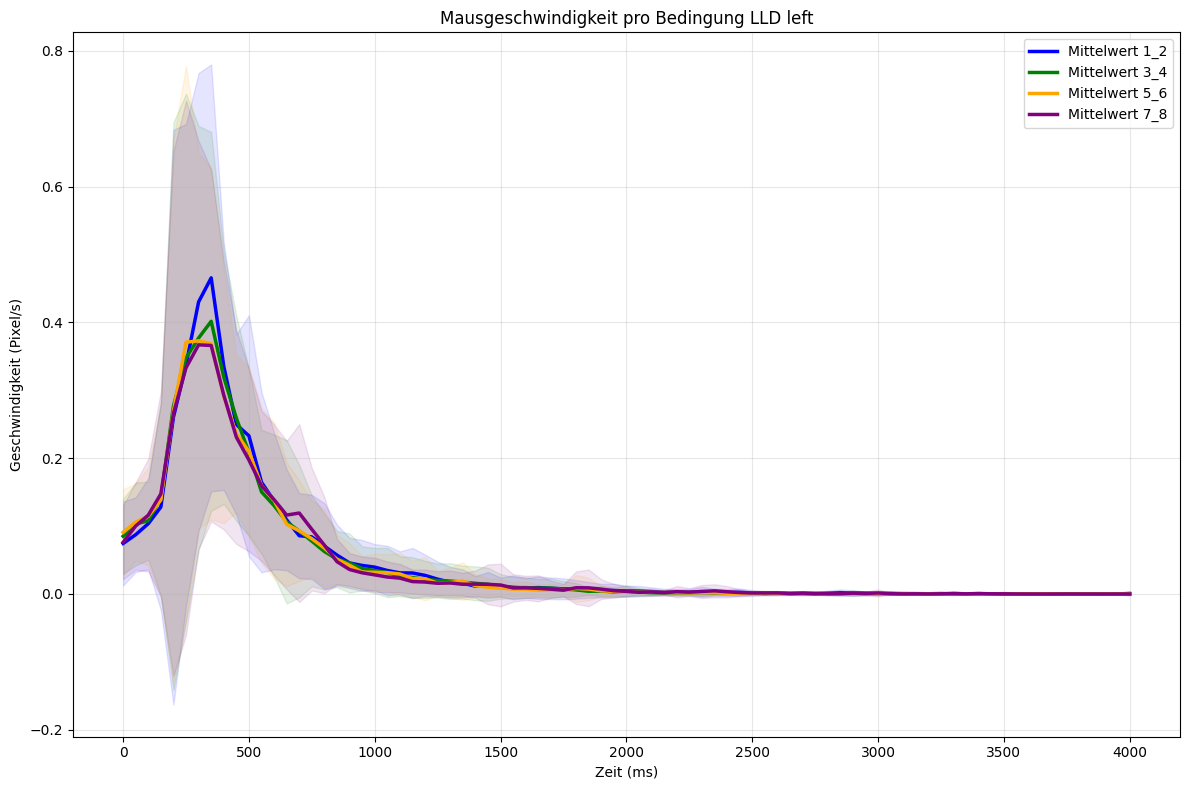

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

colors = {
    "1_2": "blue",
    "3_4": "green",
    "5_6": "orange",
    "7_8": "purple",
}

plt.figure(figsize=(12, 8))

for key, participant_speeds in avg_speed_per_participant_lld_left.items():
    if not participant_speeds:
        continue
    print(key)

    color = colors.get(key, 'gray')

    # Teilnehmerkurven (transparent)
    # for speed_data in participant_speeds:
    #     plt.plot(target_time_ms, speed_data, color=color, alpha=0.2, linewidth=1)

    # Mittelwert & Standardabweichung
    all_speeds = np.vstack(participant_speeds)
    mean_speed = np.mean(all_speeds, axis=0)
    std_speed = np.std(all_speeds, axis=0)

    # Mittelwert-Linie
    plt.plot(target_time_ms, mean_speed, color=color, linewidth=2.5, label=f'Mittelwert {key}')

    # Schattierung: ±1 SD
    plt.fill_between(target_time_ms, 
                     mean_speed - std_speed, 
                     mean_speed + std_speed, 
                     alpha=0.1, color=color)

plt.xlabel('Zeit (ms)')
plt.ylabel('Geschwindigkeit (Pixel/s)')
plt.title('Mausgeschwindigkeit pro Bedingung LLD left')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


1_2
3_4
5_6
7_8


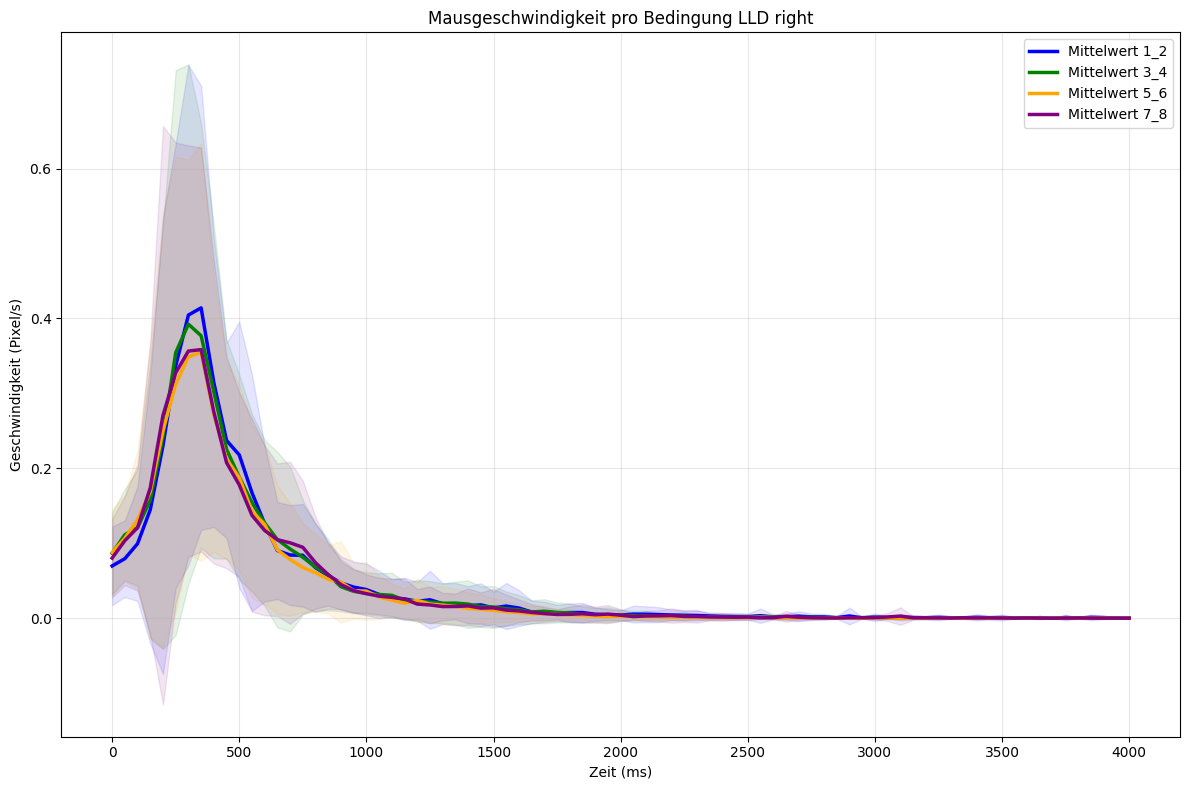

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

colors = {
    "1_2": "blue",
    "3_4": "green",
    "5_6": "orange",
    "7_8": "purple",
}

plt.figure(figsize=(12, 8))

for key, participant_speeds in avg_speed_per_participant_lld_right.items():
    if not participant_speeds:
        continue
    print(key)

    color = colors.get(key, 'gray')

    # Teilnehmerkurven (transparent)
    # for speed_data in participant_speeds:
    #     plt.plot(target_time_ms, speed_data, color=color, alpha=0.2, linewidth=1)

    # Mittelwert & Standardabweichung
    all_speeds = np.vstack(participant_speeds)
    mean_speed = np.mean(all_speeds, axis=0)
    std_speed = np.std(all_speeds, axis=0)

    # Mittelwert-Linie
    plt.plot(target_time_ms, mean_speed, color=color, linewidth=2.5, label=f'Mittelwert {key}')

    # Schattierung: ±1 SD
    plt.fill_between(target_time_ms, 
                     mean_speed - std_speed, 
                     mean_speed + std_speed, 
                     alpha=0.1, color=color)

plt.xlabel('Zeit (ms)')
plt.ylabel('Geschwindigkeit (Pixel/s)')
plt.title('Mausgeschwindigkeit pro Bedingung LLD right')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


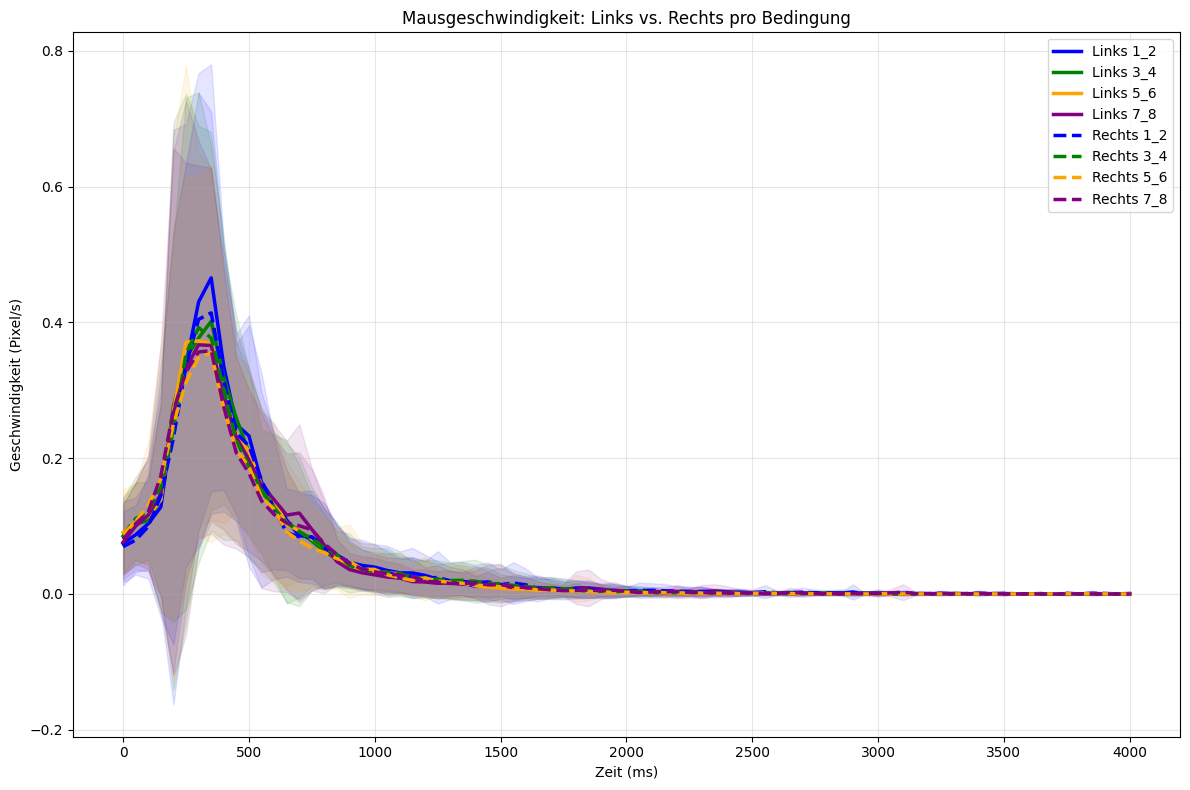

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Feste Farben pro Bedingung
colors = {
    "1_2": "blue",
    "3_4": "green",
    "5_6": "orange",
    "7_8": "purple",
}

plt.figure(figsize=(12, 8))

# Funktion zum Plotten eines Bereichs (left oder right)
def plot_condition(data_dict, side='left', linestyle='solid', alpha_individual=0.2, linewidth_mean=2.5):
    for key, participant_speeds in data_dict.items():
        if not participant_speeds:
            continue  # Überspringen, wenn leer

        color = colors.get(key, 'gray')
        label_prefix = 'Links' if side == 'left' else 'Rechts'
        linestyle_individual = '--' if side == 'right' else '-'

        # Einzelne Teilnehmer
        # for speed_data in participant_speeds:
        #     plt.plot(target_time_ms, speed_data,
        #              color=color, alpha=alpha_individual,
        #              linewidth=1, linestyle=linestyle_individual)

        # Mittelwert & SD
        all_speeds = np.vstack(participant_speeds)
        mean_speed = np.mean(all_speeds, axis=0)
        std_speed = np.std(all_speeds, axis=0)

        # Mittelwert-Linie
        plt.plot(target_time_ms, mean_speed,
                 color=color, linewidth=linewidth_mean,
                 linestyle=linestyle, label=f'{label_prefix} {key}')

        # SD-Schattierung
        plt.fill_between(target_time_ms,
                         mean_speed - std_speed,
                         mean_speed + std_speed,
                         alpha=0.1, color=color)

# Linke Bedingungen (durchgezogene Linien)
plot_condition(avg_speed_per_participant_lld_left, side='left', linestyle='solid')

# Rechte Bedingungen (gestrichelte Linien)
plot_condition(avg_speed_per_participant_lld_right, side='right', linestyle='dashed')

# Plot-Details
plt.xlabel('Zeit (ms)')
plt.ylabel('Geschwindigkeit (Pixel/s)')
plt.title('Mausgeschwindigkeit: Links vs. Rechts pro Bedingung')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
